# Keras Unet Test


학습된 모델을 불러와 제공된 테스트 이미지와 인터넷 밀 사진으로 예측


In [1]:
import numpy as np
from tqdm.notebook import tqdm

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf

from tensorflow.keras.models import Model, load_model

from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dropout, Lambda
# from tensorflow.keras.layers.core import , Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


In [2]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [3]:
from tensorflow.python.client import device_lib 

# device_lib.list_local_devices()

In [4]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
SC_FACTOR = int(1024 / IMG_WIDTH) # scale factor
print(SC_FACTOR)

2


**테스트데이터셋 준비**

In [5]:
BASE_PATH = '/home/hyerin/data/global-wheat-detection/'
TEST_PATH = os.path.join(BASE_PATH, "test/")
TEST_2_PATH = os.path.join(BASE_PATH, 'test2/')
print(TEST_PATH)
print(TEST_2_PATH)

/home/hyerin/data/global-wheat-detection/test/
/home/hyerin/data/global-wheat-detection/test2/


In [6]:
test_ids = os.listdir(TEST_PATH)    # test 데이터
test_2_ids = sorted(os.listdir(TEST_2_PATH))

In [7]:
print(test_ids)
print(test_2_ids)

['51f1be19e.jpg', '348a992bb.jpg', 'f5a1f0358.jpg', '2fd875eaa.jpg', 'cb8d261a3.jpg', '51b3e36ab.jpg', '796707dd7.jpg', 'aac893a91.jpg', '53f253011.jpg', 'cc3532ff6.jpg']
['wheat_test_1.jpg', 'wheat_test_10.jpg', 'wheat_test_2.jpg', 'wheat_test_3.jpg', 'wheat_test_4.jpg', 'wheat_test_5.jpg', 'wheat_test_6.jpg', 'wheat_test_7.jpg', 'wheat_test_8.jpg', 'wheat_test_9.jpg']


In [8]:
def display_images_from_directory(images, row, col, path, fig_size=(20,8)): 
    f, ax = plt.subplots(row, col, figsize=fig_size)
    for i, image_id in enumerate(images):
        image_path = os.path.join(path, f'{image_id}') #.jpg')
        image = Image.open(image_path)        
            
        ax[i//col, i%col].imshow(image) 
        ax[i//col, i%col].axis('off')
        ax[i//col, i%col].set_title(f"image_id: {image_id}")

    plt.show()

**제공된 테스트 이미지**

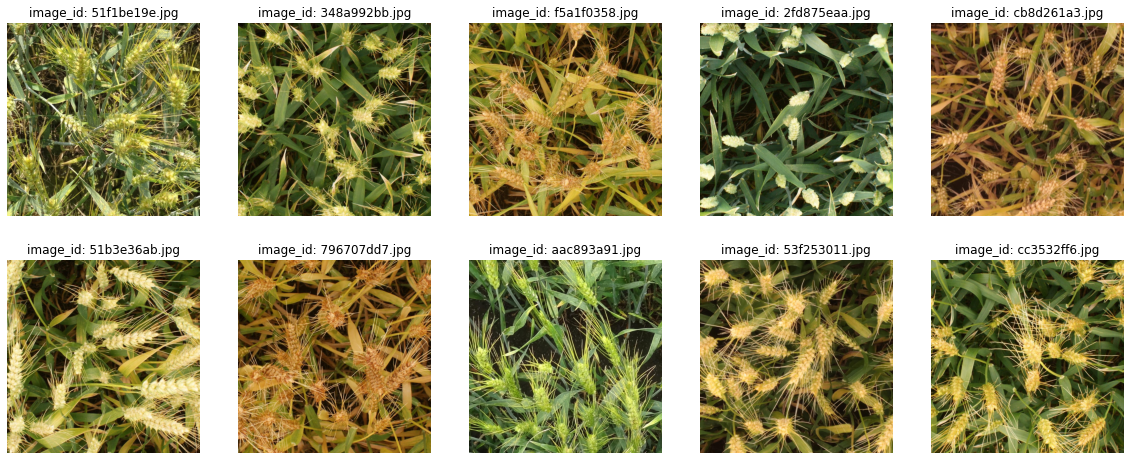

In [9]:
display_images_from_directory(test_ids, 2, 5, TEST_PATH)

**인터넷에서 수집한 테스트 이미지**

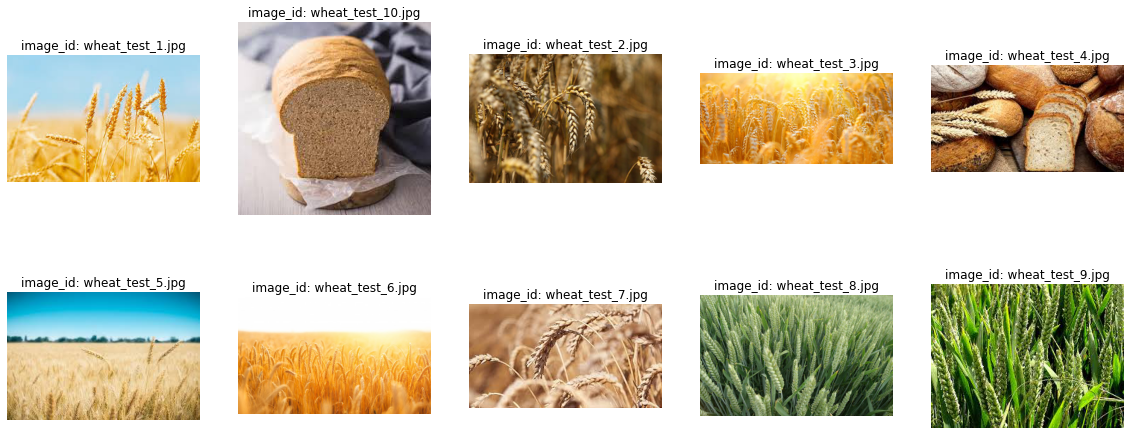

In [10]:
display_images_from_directory(test_2_ids, 2, 5, TEST_2_PATH)

**Test에 사용될 이미지 Resize**

In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images...


  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# Get and resize test images
X_test_2 = np.zeros((len(test_2_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test 2 images...')

for n, id_ in tqdm(enumerate(test_2_ids), total=len(test_2_ids)):
    path = TEST_2_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_2[n] = img

Getting and resizing test 2 images...


  0%|          | 0/10 [00:00<?, ?it/s]

**Resize된 테스트 이미지 확인**

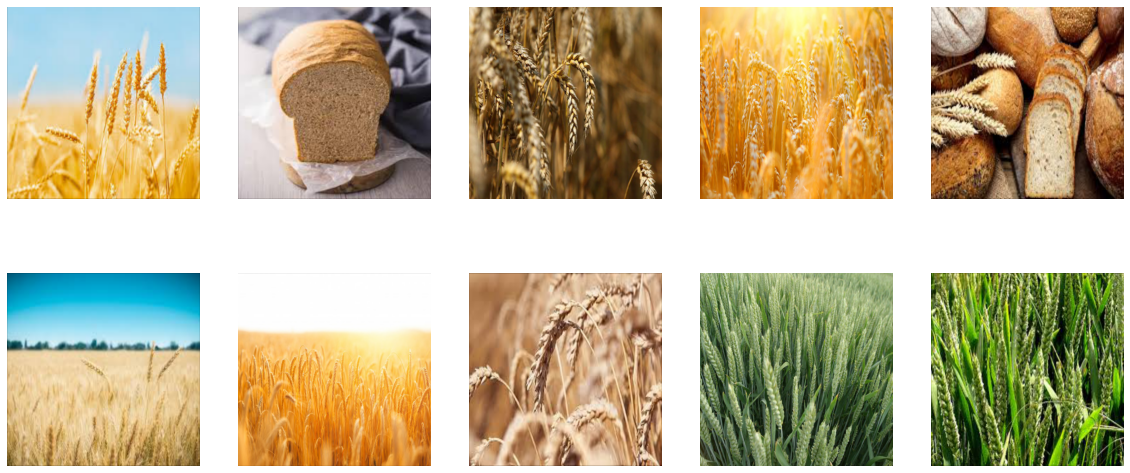

In [13]:
row=2
col=5
fig_size = (20,9)
f, ax = plt.subplots(row, col, figsize=fig_size)
for i, image in enumerate(X_test_2):
    ax[i//col, i%col].imshow(image) 
    ax[i//col, i%col].axis('off')
plt.show()

In [14]:
print("X_test.shape :", X_test.shape)
print("X_test_2.shape :", X_test_2.shape)

X_test.shape : (10, 512, 512, 3)
X_test_2.shape : (10, 512, 512, 3)


**학습된 모델 불러오기**<br><br>
load_model가 되지 않는 문제 있음<br>
load_weights 사용해서 해결<br>
**참고**
https://stackoverflow.com/questions/53212672/read-only-mode-in-keras<br>

In [15]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [16]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [17]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

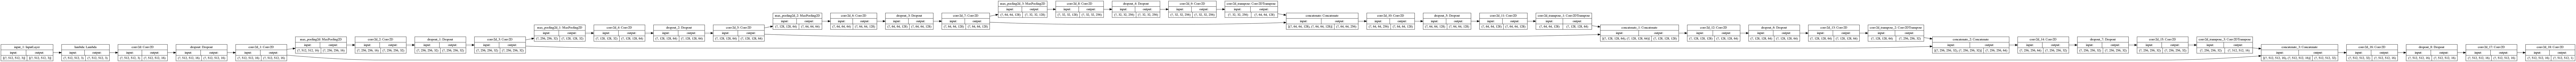

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, rankdir='LR')
from IPython.display import Image
Image('model.png')

In [19]:
model.load_weights('wheat_detection_unet_210630.h5')

**제공된 Test 이미지로 예측**

In [20]:
THRESH = 0.65

In [32]:
x_test_prediction = model.predict(X_test)[:, :, :, 0] # output 모양 (??, 512, 512, 1) -> (??, 512, 512)
masked_preds = x_test_prediction > THRESH
print(x_test_prediction.shape)

(10, 512, 512)


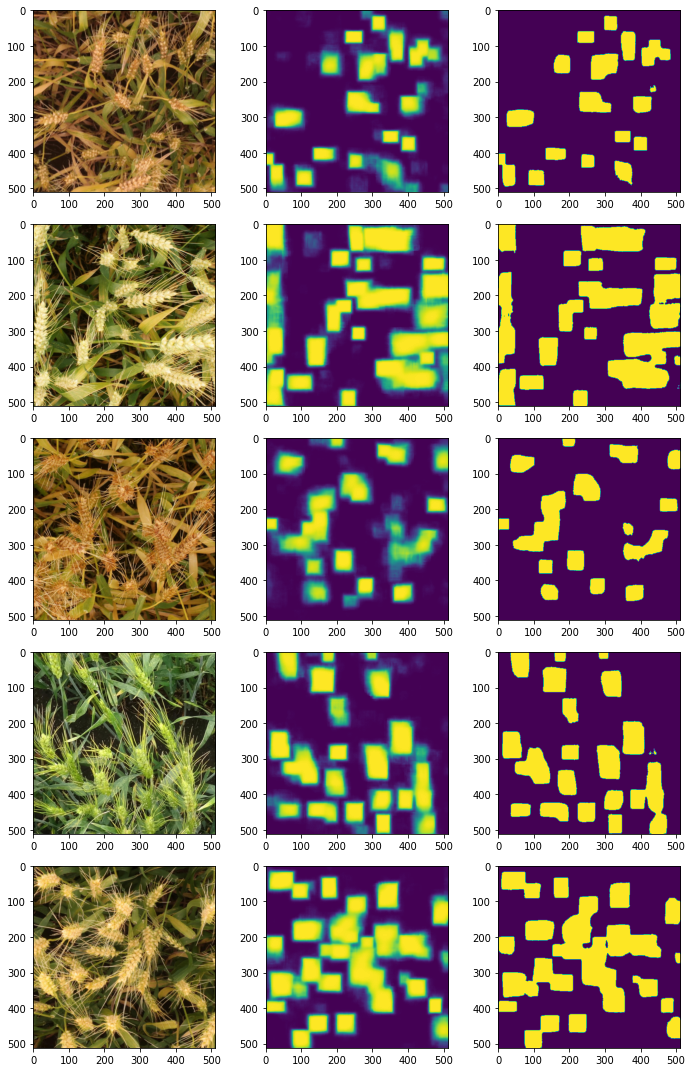

In [33]:
n_rows = 5
n_cols= 3
f, ax = plt.subplots(n_rows, n_cols, figsize=(10, 15))
for j, idx in enumerate([4,5,6,7,8]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = x_test_prediction[idx]
        elif kind == 'masked_pred':
            masked_pred = x_test_prediction[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)
plt.tight_layout()

In [34]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [35]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):    #10
    label_j = label(masked_preds[j, :, :])  #label을 통해 정수배열의 연결된 영역에 레이블 지정
    props = regionprops(label_j)   # 레이블이 있는 영역 이미지의 속성을 측정
#     print(props)
    bboxes.append(props)

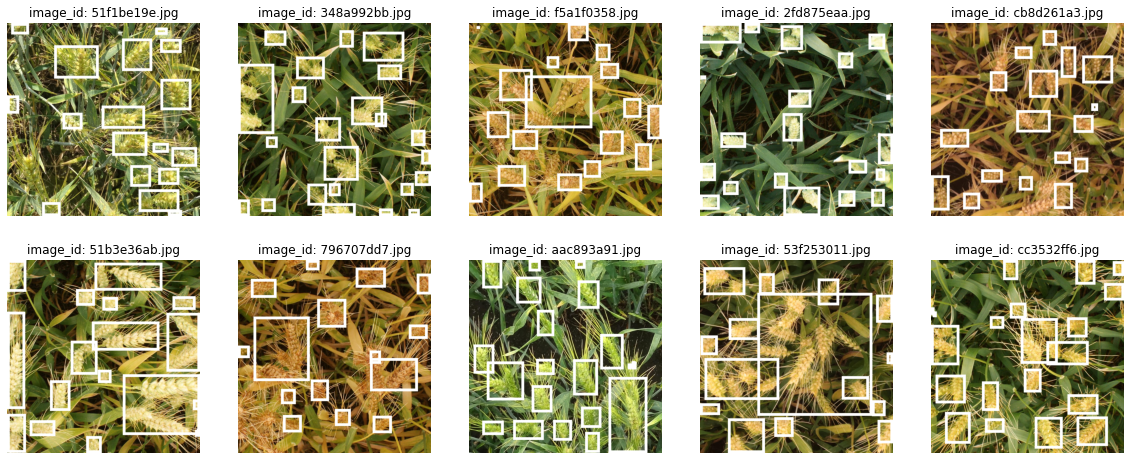

In [36]:
from PIL import Image, ImageDraw

row=2
col=5
f, ax = plt.subplots(row,col, figsize=(20, 8))
for i, image_id in enumerate(test_ids):
    
    test_bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
#     print(image_id," ", test_bboxes_processed," \n")
    image_path = os.path.join(TEST_PATH, f'{image_id}')
    image = Image.open(image_path)    
    draw = ImageDraw.Draw(image)
    for test_bbox in test_bboxes_processed:    
        draw.rectangle([test_bbox[0], test_bbox[1], 
                        test_bbox[0] + test_bbox[2], test_bbox[1] + test_bbox[3]], 
                        width=15)
    ax[i//col, i%col].imshow(image) 
    ax[i//col, i%col].axis('off')
    ax[i//col, i%col].set_title(f"image_id: {image_id}")

plt.show()

**인터넷에서 찾은 Test 이미지로 예측**

인터넷에서 찾은 이미지가 제공된 데이터셋만큼 깔끔하지 않다.<br>
밀이 없는 사진에서 mask가 생기지 않는 것도 확인 가능<br>
<br>
**데이터셋 만든 방법**
https://arxiv.org/abs/2005.02162


In [23]:
x_test_2_prediction = model.predict(X_test_2)[:, :, :, 0] # output 모양 (??, 512, 512, 1) -> (??, 512, 512)
masked_prediction_2 = x_test_2_prediction > THRESH
print(x_test_2_prediction.shape)
print(masked_prediction_2.shape)

(10, 512, 512)
(10, 512, 512)


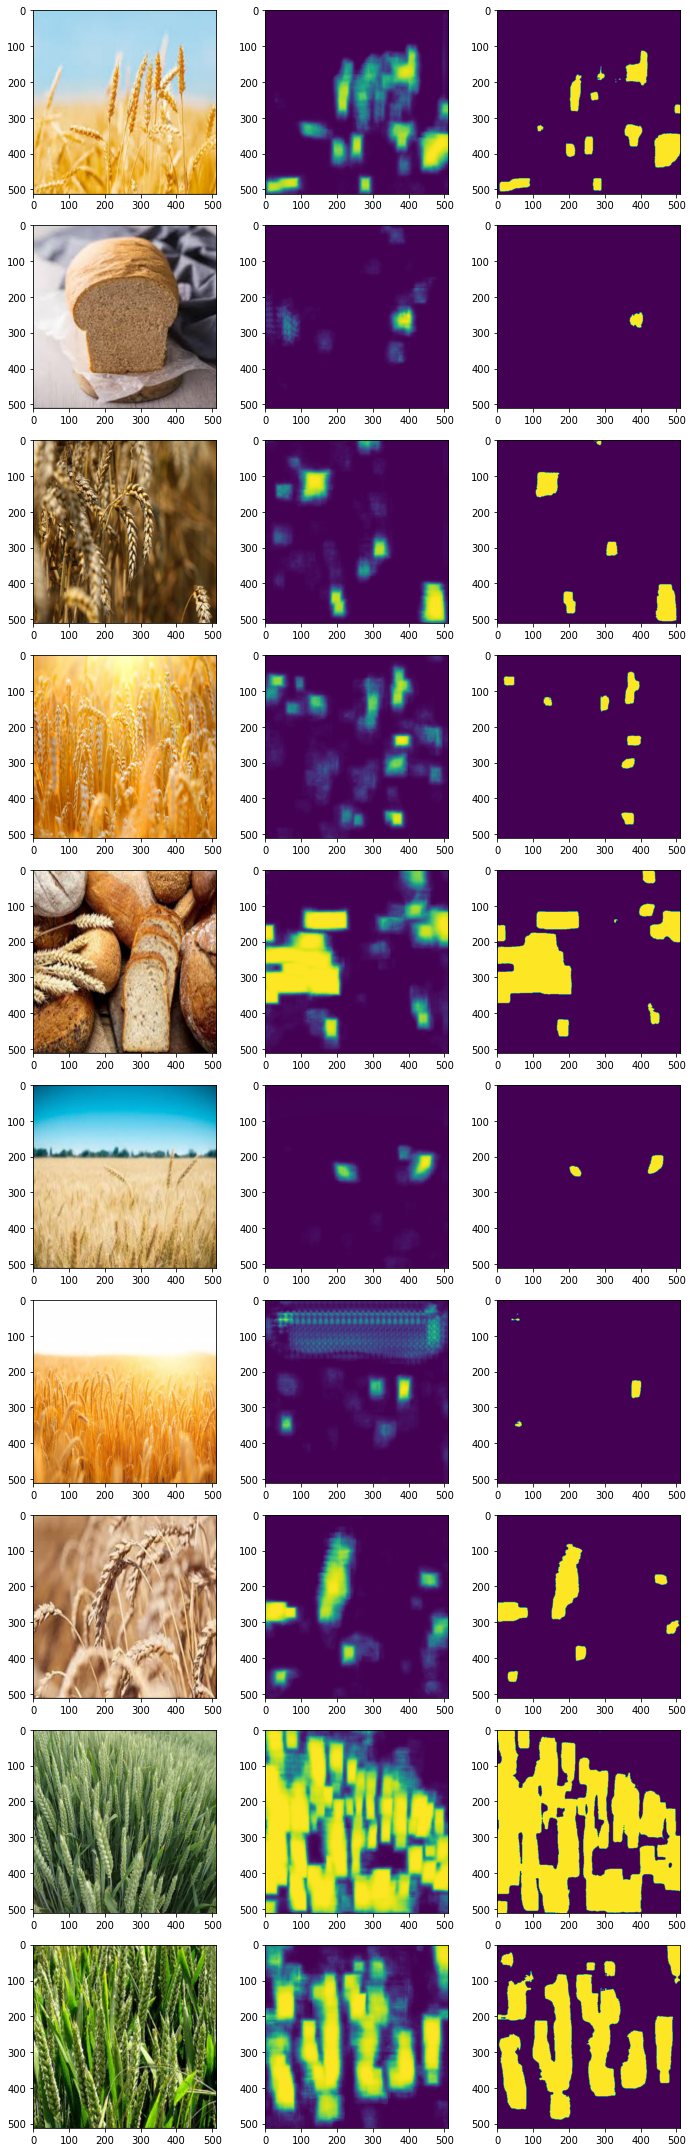

In [24]:
n_rows = 10
n_cols= 3
f, ax = plt.subplots(n_rows, n_cols, figsize=(10, 30))
for j, idx in enumerate([0,1,2,3,4,5,6,7,8,9]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test_2[idx]
        elif kind == 'pred':
            img = x_test_2_prediction[idx]
        elif kind == 'masked_pred':
            masked_pred_2 = x_test_2_prediction[idx] > THRESH # 확률이 높은 것만 밀로 본다
            img = masked_pred_2
        ax[j, k].imshow(img)
plt.tight_layout()